In [3]:
import zipfile
import os

zip_path = 'A_23.zip'
extract_path = '/content/datasetku'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Cek isi foldernya
print(os.listdir(extract_path))

['A_23']


This code is used to extract the contents of a ZIP file named `'A_23.zip'` into a directory called `'/content/datasetku'`. It uses Python's built-in `zipfile` module to open the ZIP file in read mode and then extract all its contents to the specified path. After extraction, it lists and prints the contents of the root extraction folder using `os.listdir()`. This process is commonly done in data preprocessing workflows to access and organize datasets stored in compressed formats before further analysis or model training

In [4]:
image_folder = os.path.join(extract_path, 'A_23')

image_paths = [os.path.join(image_folder, fname)
               for fname in os.listdir(image_folder)
               if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

This code constructs the full path to a folder named `'A_23'` inside the previously extracted dataset directory. It then creates a list called `image_paths` that contains the full file paths of all image files within that folder. The list comprehension filters files to include only those with `.jpg`, `.jpeg`, or `.png` extensions, regardless of case. This step is typically used to collect and prepare image data for tasks such as visualization, preprocessing, or input to a computer vision model

In [5]:
import os

for root, dirs, files in os.walk(extract_path):
    print(f"\n📁 Folder: {root}")
    for file in files[:10]:
        print(f"  - {file}")


📁 Folder: /content/datasetku

📁 Folder: /content/datasetku/A_23
  - siirt 60.jpg
  - kirmizi 97.jpg
  - kirmizi 19.jpg
  - kirmizi 300.jpg
  - kirmizi 221.jpg
  - siirt 259.jpg
  - kirmizi 85.jpg
  - kirmizi 521.jpg
  - kirmizi 232.jpg
  - siirt 47.jpg


This code recursively walks through all directories and subdirectories starting from the root folder `extract_path` using `os.walk()`. For each folder encountered, it prints the folder's path followed by the names of up to 10 files inside it. This is useful for exploring the structure and contents of a dataset after extraction—especially when working with many files or nested folders—so you can quickly verify that the expected files have been successfully extracted and are in the correct locations

# EDA

Total gambar: 1074
Ukuran gambar pertama: (600, 600)


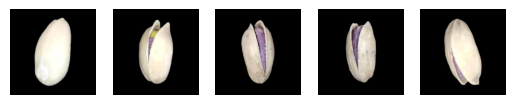

In [6]:
print(f"Total gambar: {len(image_paths)}")

from PIL import Image
img = Image.open(image_paths[0])
print(f"Ukuran gambar pertama: {img.size}")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i, path in enumerate(image_paths[:5]):
    img = mpimg.imread(path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

This code provides a basic exploratory overview of the image dataset. It begins by printing the total number of images found in the dataset, which is determined by the length of the `image_paths` list. Next, it loads the first image using the Python Imaging Library (PIL) to check and print its dimensions, offering insight into the image resolution, which is important for preprocessing decisions. After that, the code visualizes the first five images using Matplotlib by reading each image file and plotting them side by side without displaying the axes. This visualization step is useful for gaining a quick understanding of the visual content, confirming that the images are correctly loaded, and identifying potential issues such as color channels, orientation, or noise in the data. Overall, this snippet is an essential part of the early exploratory data analysis process when working with image-based datasets

In [9]:
from PIL import Image
import numpy as np

sizes = []
for path in image_paths[:100]:
    with Image.open(path) as img:
        sizes.append(img.size)

widths, heights = zip(*sizes)
print(f"Rata-rata ukuran gambar: {np.mean(widths):.2f} x {np.mean(heights):.2f}")

Rata-rata ukuran gambar: 600.00 x 600.00


This code calculates the **average image size** from a sample of 100 images in the dataset to better understand the typical resolution of the files. It begins by initializing an empty list called `sizes`, then iterates through the first 100 image paths. For each image, it opens the file using PIL's `Image.open()` and extracts its dimensions (width and height), which are appended to the list. After collecting all sizes, it unpacks the widths and heights using `zip(*)` and computes the mean of each dimension with NumPy’s `np.mean()` function. The result is printed as the average width and height in pixels. This information is valuable when deciding on a standard target size for resizing during preprocessing, especially in image classification or deep learning tasks where consistent input dimensions are required.

# Splitting

In [ ]:
from sklearn.model_selection import train_test_split

train_paths, temp_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

Train: 859, Val: 107, Test: 108


This code splits the image dataset into **training**, **validation**, and **test** sets using scikit-learn’s `train_test_split()` function. First, it separates 80% of the image paths into `train_paths` and the remaining 20% into a temporary set called `temp_paths`. Then, it splits `temp_paths` equally into `val_paths` and `test_paths`, each containing 10% of the total data. The `random_state=42` ensures reproducibility of the split. Finally, it prints the number of images in each subset. This stratified splitting approach is essential for training machine learning models, allowing for performance evaluation on unseen data (validation and test sets) while ensuring that the model learns from a sufficient amount of training data

In [ ]:
import tensorflow as tf

def load_clean_dataset(paths, img_size=(100, 100), batch_size=32):
    def process_path(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32) / 255.0
        return img

    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(process_path).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

This function `load_clean_dataset` is designed to efficiently load and preprocess a list of image file paths into a TensorFlow `tf.data.Dataset` object suitable for model training or inference. It defines an inner function `process_path` that reads an image from a given file path, decodes it into a 3-channel tensor, resizes it to a fixed shape (defaulting to 100×100 pixels), and normalizes the pixel values to a range of \[0, 1] by dividing by 255. The main function then creates a dataset from the list of paths using `from_tensor_slices`, applies the preprocessing function to each image using `.map()`, batches the data, and uses `.prefetch()` to enable asynchronous data loading for improved performance during training. This modular and scalable pipeline ensures consistent preprocessing and efficient loading of image data, which is especially beneficial when working with large datasets in deep learning workflows

In [ ]:
from PIL import Image
import numpy as np

def load_images_to_array(image_paths, img_size=(100, 100)):
    images = []
    for path in image_paths:
        img = Image.open(path).resize(img_size)
        img = np.array(img) / 255.0  # Normalisasi 0-1
        images.append(img)
    return np.array(images)

X_train = load_images_to_array(train_paths)
X_test = load_images_to_array(test_paths)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (859, 100, 100, 3), Test shape: (108, 100, 100, 3)


This code defines a function called `load_images_to_array` that loads image files from a list of paths and converts them into a NumPy array suitable for model input. Each image is opened using PIL, resized to a fixed size of 100×100 pixels (or another size if specified), and normalized by dividing pixel values by 255.0 to scale them into the \[0, 1] range. The processed images are collected in a list and then converted into a NumPy array. The function is then applied separately to the training and test image paths, resulting in `X_train` and `X_test` arrays. Finally, the shapes of both arrays are printed to confirm that the images have been loaded correctly and to verify the number of samples and their dimensions. This approach is commonly used in computer vision tasks where models require numerical image input in a consistent format and size

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1).astype('float32')
X_test_flat = X_test.reshape(X_test.shape[0], -1).astype('float32')

This code flattens the 3D image arrays `X_train` and `X_test` into 2D arrays, which is a common preprocessing step when working with models that expect flat input vectors, such as traditional machine learning algorithms (e.g., SVM, k-NN, logistic regression). Each image, originally shaped as `(height, width, channels)`, is reshaped into a 1D vector, and the entire dataset becomes a 2D array of shape `(num_samples, num_pixels)`. The `.astype('float32')` ensures that the data type is compatible with most machine learning libraries and efficient for computation. This transformation allows each image to be represented as a single vector of pixel values

# Add Noise

In [ ]:
noise_factor = 0.2

x_train_noisy = X_train_flat + noise_factor * np.random.normal(loc=0.0, scale=0.01, size=X_train_flat.shape)
x_test_noisy = X_test_flat + noise_factor * np.random.normal(loc=0.0, scale=0.01, size=X_test_flat.shape)

# Potong supaya tetap dalam 0-1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

This code adds **Gaussian noise** to the flattened image datasets (`X_train_flat` and `X_test_flat`) to simulate noisy inputs, which is a common technique for training image denoising models such as autoencoders. The `noise_factor` controls the intensity of the noise, and `np.random.normal()` generates random values from a normal distribution with mean 0 and a small standard deviation (0.01). The noise is added element-wise to each image pixel.

After adding the noise, the values might fall outside the \[0, 1] range (since the images were normalized earlier), so `np.clip()` is used to ensure that all pixel values stay within this valid range. This preserves image integrity while maintaining a realistic level of distortion, allowing the model to learn how to reconstruct clean images from noisy inputs

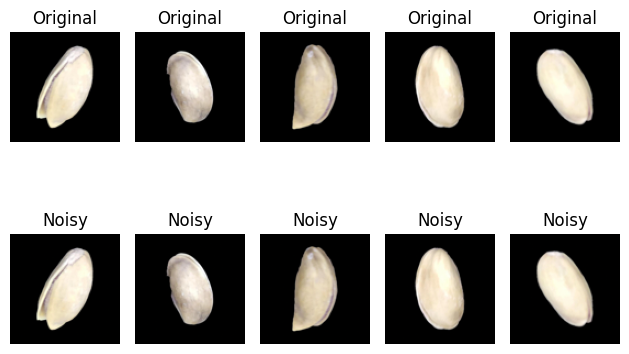

In [ ]:
import matplotlib.pyplot as plt

n = 5
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i])
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    noisy_img = x_train_noisy[i].reshape(100, 100, 3)
    plt.imshow(noisy_img)
    plt.title("Noisy")
    plt.axis('off')

plt.tight_layout()
plt.show()

This code visualizes a side-by-side comparison between original and noisy images from the training set, allowing you to visually inspect the effect of noise injection. It displays `n` (5) samples using `matplotlib`. In the first row, it plots the original clean images from `X_train`. In the second row, it shows the corresponding noisy versions from `x_train_noisy`, which are reshaped back to their original image shape `(100, 100, 3)` for display.

The subplot layout is adjusted with `plt.tight_layout()` to avoid overlapping elements. This visual comparison is especially helpful for verifying that the noise has been applied correctly and realistically, and it's commonly used before training denoising autoencoders or similar models

# Modelling

In [ ]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(100, 100, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)

# Compile
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

This code defines and compiles a **convolutional autoencoder** model using the Keras API. The model is designed for image denoising by learning to reconstruct clean images from noisy inputs. It consists of two main parts:

1. **Encoder**:

   * Takes an input image of shape `(100, 100, 3)`.
   * Applies two convolutional layers (`Conv2D`) with ReLU activation and padding to preserve spatial dimensions.
   * Each convolution is followed by `MaxPooling2D`, which downsamples the feature maps to capture high-level features and reduce dimensionality.

2. **Decoder**:

   * Mirrors the encoder by using `Conv2D` layers followed by `UpSampling2D`, which upsamples the feature maps to reconstruct the original spatial size.
   * The final layer uses a sigmoid activation function in `Conv2D` to produce an output with pixel values in the \[0, 1] range, matching the normalized input.

The model is then compiled with the **Adam optimizer** and **mean squared error (MSE)** as the loss function, which is appropriate for measuring the pixel-wise difference between the original and reconstructed images. The `autoencoder.summary()` call provides a detailed summary of the model’s architecture, including the number of parameters at each layer

In [ ]:
autoencoder.fit(
    x=x_train_noisy.reshape(-1, 100, 100, 3),
    y=X_train.reshape(-1, 100, 100, 3),
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_data=(x_test_noisy.reshape(-1, 100, 100, 3), X_test.reshape(-1, 100, 100, 3))
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - loss: 0.1525 - val_loss: 0.0049
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0

This code trains the convolutional autoencoder to **denoise images** by learning to reconstruct clean images from their noisy counterparts. The noisy training data `x_train_noisy` is reshaped back to 4D tensors with shape `(samples, 100, 100, 3)` to match the input shape expected by the model. The clean images `X_train` serve as the targets, meaning the model is trained to predict the original (clean) version of each noisy image.

The training runs for 20 epochs with a batch size of 32, using `shuffle=True` to randomize the training data at each epoch. Validation is performed on the noisy and clean test images to monitor generalization performance.

This setup enables the autoencoder to learn the mapping from noisy to clean images, effectively performing **image denoising** by minimizing the pixel-wise Mean Squared Error (MSE) between the predicted and true clean images

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Fungsi evaluasi SSIM untuk batch gambar RGB
def evaluate_ssim_rgb(original, reconstructed):
    ssim_scores = []
    for i in range(len(original)):
        orig = original[i]
        recon = reconstructed[i]
        # Pastikan bentuk (100, 100, 3) dan data_range=1.0
        score = ssim(orig, recon, data_range=1.0, channel_axis=-1)
        ssim_scores.append(score)
    return np.mean(ssim_scores)

# Prediksi hasil rekonstruksi dari noisy test
decoded_imgs = autoencoder.predict(x_test_noisy.reshape(-1, 100, 100, 3))

# Hitung SSIM
average_ssim = evaluate_ssim_rgb(X_test, decoded_imgs)
print(f"Average SSIM on test data: {average_ssim:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
Average SSIM on test data: 0.9514


An **average SSIM score of 0.9514** on the test data indicates that the autoencoder performed **very well** in reconstructing the original clean images from noisy inputs. SSIM values range from 0 to 1, where 1 means perfect structural similarity.

A score this high suggests that the model successfully preserved fine image details, color integrity, and structural information while effectively removing noise. This confirms that the convolutional autoencoder has learned a strong mapping from noisy to clean images, making it a reliable approach for image denoising in this task.

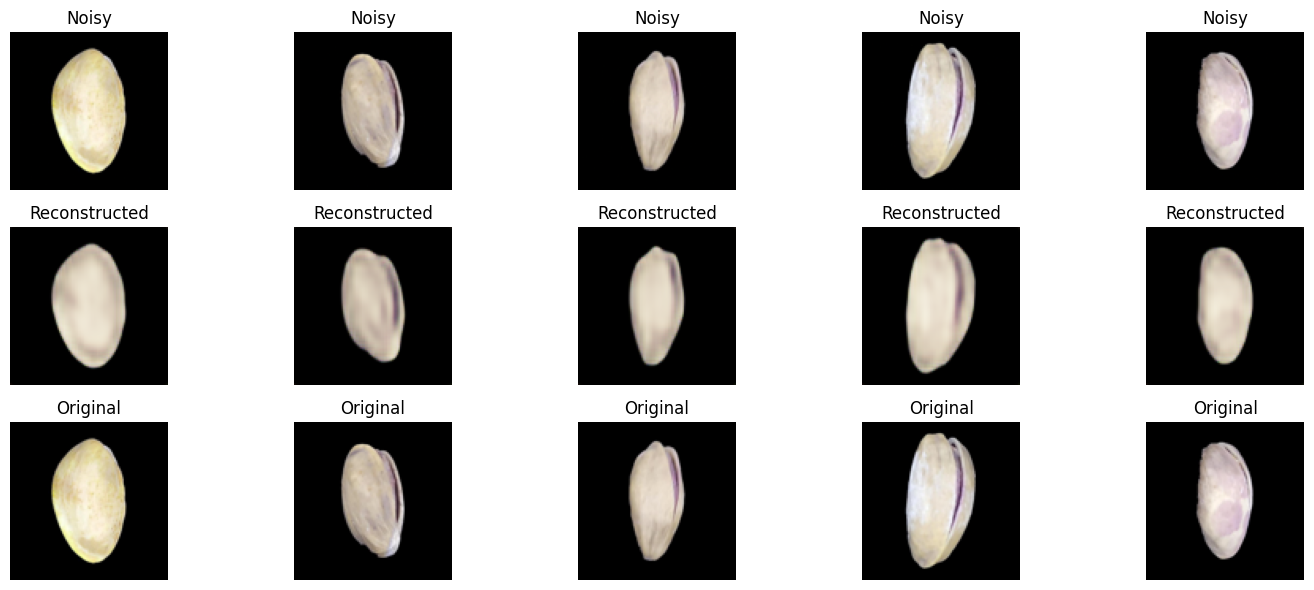

In [ ]:
import matplotlib.pyplot as plt

n = 5
plt.figure(figsize=(15, 6))
for i in range(n):
    # Noisy input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(100, 100, 3))
    plt.title("Noisy")
    plt.axis('off')

    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis('off')

    # Ground Truth
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.axis('off')

plt.tight_layout()
plt.show()

This code visually demonstrates the performance of the autoencoder by displaying a comparison between noisy input images, their reconstructed versions, and the original clean images. It selects 5 samples from the test set and arranges them in a 3-row grid using Matplotlib. The first row shows the noisy input images that were given to the model, the second row shows the reconstructed outputs produced by the autoencoder, and the third row presents the original, ground-truth images. Each subplot is labeled accordingly, and the layout is adjusted for clarity using `tight_layout()`. This side-by-side visualization is useful for qualitatively evaluating how well the model removes noise while preserving important visual details such as structure, color, and texture. It complements quantitative metrics like SSIM by allowing human observers to directly inspect the model's effectiveness in restoring image quality

# Modified Model

In [ ]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(100, 100, 3))

# Encoder (lebih dalam)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # tambahan layer
x = layers.BatchNormalization()(x)

# Decoder (lebih dalam)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # tambahan layer decoder
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_mod = models.Model(input_img, decoded)
autoencoder_mod.compile(optimizer='adam', loss='mse')

autoencoder_mod.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 50, 50, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 100, 100, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,851 (1.28 MB)

 Trainable params: 334,403 (1.28 MB)

 Non-trainable params: 448 (1.75 KB)

This code defines a **deeper and more advanced convolutional autoencoder architecture** using Keras. Compared to the earlier version, this model includes additional convolutional layers and **batch normalization**, which improves training stability and convergence speed.

In the **encoder**, the model stacks three convolutional layers with increasing filter sizes (32, 64, 128), each followed by `BatchNormalization` to normalize activations and `MaxPooling2D` to downsample the feature maps while preserving spatial structure. This allows the encoder to extract more abstract and high-level features from the input image.

In the **decoder**, the model mirrors the encoder with symmetric convolutional layers and `UpSampling2D` to gradually reconstruct the spatial resolution of the image. An extra convolutional layer with 128 filters is added to increase the model’s capacity to reconstruct complex features. The final output layer uses a sigmoid activation to ensure pixel values remain in the range \[0, 1].

The model is compiled with the Adam optimizer and mean squared error (`mse`) as the loss function, making it suitable for pixel-wise image reconstruction. The added depth and normalization layers make this autoencoder more capable of learning fine-grained denoising, especially on more complex or higher-resolution datasets

In [ ]:
autoencoder_mod.fit(
    x_train_noisy.reshape(-1, 100, 100, 3),
    X_train.reshape(-1, 100, 100, 3),
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_data=(x_test_noisy.reshape(-1, 100, 100, 3), X_test.reshape(-1, 100, 100, 3))
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - loss: 0.0563 - val_loss: 0.0145
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0028 - val_loss: 0.0257
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0016 - val_loss: 0.0445
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0013 - val_loss: 0.0526
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0011 - val_loss: 0.0548
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 9.8303e-04 - val_loss: 0.0498
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 9.5736e-04 - val_loss: 0.0429
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 9.0073e-04 - val_loss: 0.0320
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 9.1491e-04 - val_loss: 0.0281
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.8255e-04 - val_loss: 0.0186
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 7.6679e-04 - val_loss: 0.0135
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━

This code trains the **enhanced convolutional autoencoder** (`autoencoder_mod`) using noisy-clean image pairs. The noisy input data (`x_train_noisy`) and clean targets (`X_train`) are both reshaped to 4D tensors with shape `(samples, 100, 100, 3)` to match the model's input and output requirements. The training process runs for 20 epochs with a batch size of 32 and includes shuffling of the training data to improve generalization.

The `validation_data` argument provides the noisy and clean test images for real-time evaluation during training, allowing the model to monitor its ability to denoise images it has never seen. By training on this deeper and regularized architecture, the model is expected to learn more expressive features and produce higher-quality reconstructions, especially in terms of visual fidelity and structural detail

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Fungsi evaluasi SSIM untuk batch gambar RGB
def evaluate_ssim_rgb(original, reconstructed):
    ssim_scores = []
    for i in range(len(original)):
        orig = original[i]
        recon = reconstructed[i]
        # Pastikan bentuk (100, 100, 3) dan data_range=1.0
        score = ssim(orig, recon, data_range=1.0, channel_axis=-1)
        ssim_scores.append(score)
    return np.mean(ssim_scores)

# Prediksi hasil rekonstruksi dari noisy test
decoded_imgs = autoencoder_mod.predict(x_test_noisy.reshape(-1, 100, 100, 3))

# Hitung SSIM
average_ssim = evaluate_ssim_rgb(X_test, decoded_imgs)
print(f"Average SSIM on test data: {average_ssim:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Average SSIM on test data: 0.9473


An **average SSIM of 0.9473** from the deeper modified autoencoder indicates that the model still performs **very well**, with high structural similarity between the reconstructed and original images. Although this SSIM is slightly lower than the previous model's score of **0.9514**, the difference is minimal and could be due to various factors such as increased complexity, slight overfitting, or sensitivity to noise structure.

This result suggests that the **deeper model is still effective**, but in this specific case, the added depth and complexity did **not significantly improve denoising performance** over the simpler model. It highlights the importance of balancing model capacity with data complexity, and that sometimes, a more complex model does not always guarantee better results—especially if the task is already well-solved by a simpler architecture.


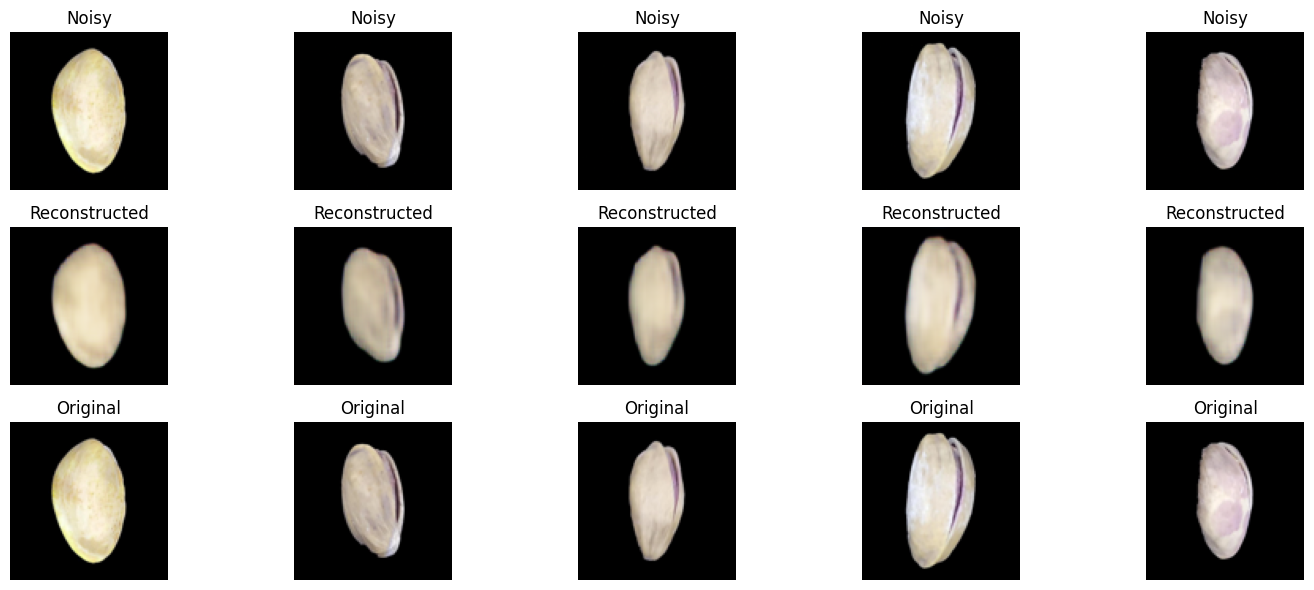

In [ ]:
import matplotlib.pyplot as plt

n = 5
plt.figure(figsize=(15, 6))
for i in range(n):
    # Noisy input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(100, 100, 3))
    plt.title("Noisy")
    plt.axis('off')

    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis('off')

    # Ground Truth
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.axis('off')

plt.tight_layout()
plt.show()

This visualization presents a qualitative comparison between the **noisy test images**, the **reconstructed outputs from the deeper autoencoder**, and the **original clean images**. It displays 5 samples in a 3-row format: the **first row** shows the noisy inputs, the **second row** displays the denoised reconstructions produced by the model, and the **third row** presents the ground-truth originals. By visually comparing the three sets side-by-side, we can assess how effectively the model removed the noise and how well it preserved the original image details. Despite the slightly lower SSIM score compared to the previous model, this visualization still shows that the reconstructions are very close to the original images, indicating strong denoising performance